In [ ]:
%load_ext autoreload
%autoreload 2

In [80]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from input import Input_Data

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data = Input_Data()
data.load_data("./data_cache/station_features_v2.csv")
data.init_split()

In [68]:
from gpt import main
transformer_losses = main()

14.436609 M parameters
step 0: train loss 0.23942928, val loss 0.24022846, time 70.10255980491638
step 500: train loss 0.00004027, val loss 0.00001352, time 282.270122051239
step 1000: train loss 0.00004633, val loss 0.00001413, time 491.2190499305725
step 1500: train loss 0.00005489, val loss 0.00001394, time 710.9425427913666
step 2000: train loss 0.00002864, val loss 0.00001131, time 917.0289299488068
step 2500: train loss 0.00003206, val loss 0.00001181, time 1122.8110029697418
step 3000: train loss 0.00003493, val loss 0.00001552, time 1337.8979234695435
step 3500: train loss 0.00003432, val loss 0.00001729, time 1546.1268293857574
step 4000: train loss 0.00002338, val loss 0.00001738, time 1752.3808710575104
step 4500: train loss 0.00001290, val loss 0.00001100, time 1959.2341091632843
step 4999: train loss 0.00001744, val loss 0.00001125, time 2168.999054670334


In [84]:
from gpt import main
transformer_losses_v2 = main()

14.187649 M parameters
step 0: train loss 0.43323013, val loss 0.43383113, time 124.61877918243408
step 500: train loss 0.00003523, val loss 0.00001109, time 484.2344901561737
step 1000: train loss 0.00004557, val loss 0.00001397, time 671.392936706543
step 1500: train loss 0.00004081, val loss 0.00001282, time 858.028213262558
step 2000: train loss 0.00006399, val loss 0.00001206, time 1044.949501991272
step 2500: train loss 0.00003576, val loss 0.00001336, time 1233.1003937721252
step 3000: train loss 0.00004318, val loss 0.00001225, time 1421.6061568260193
step 3500: train loss 0.00006306, val loss 0.00001829, time 1609.9348318576813
step 4000: train loss 0.00003999, val loss 0.00001333, time 1798.0440735816956
step 4500: train loss 0.00003045, val loss 0.00001400, time 1985.6616206169128
step 4999: train loss 0.00001513, val loss 0.00001308, time 2173.9838078022003


In [87]:
from linear import main
model, linear_losses = main()
torch.save(model.state_dict(), "./data_cache/five_years_linear.model")

step 0: train loss 0.00004789, val loss 0.00001929, time 41.40468168258667
step 500: train loss 0.00000449, val loss 0.00000309, time 124.58374094963074
step 1000: train loss 0.00000570, val loss 0.00000326, time 210.98066401481628
step 1500: train loss 0.00000672, val loss 0.00000336, time 299.1862533092499
step 2000: train loss 0.00000336, val loss 0.00000233, time 385.1544406414032
step 2500: train loss 0.00000517, val loss 0.00000287, time 470.40161180496216
step 3000: train loss 0.00000451, val loss 0.00000284, time 556.8663477897644
step 3500: train loss 0.00000475, val loss 0.00000254, time 642.7621185779572
step 4000: train loss 0.00000458, val loss 0.00000257, time 729.2549500465393
step 4500: train loss 0.00000390, val loss 0.00000323, time 814.482931137085
step 4999: train loss 0.00000422, val loss 0.00000243, time 900.2852935791016


In [65]:
from gpt import PM25TransformerModel, batch_size, block_size, stations_in_batch

torch.no_grad()
#model = nn.Transformer(nhead=8, d_model=256, dropout=0.2, num_decoder_layers=6)
model = PM25TransformerModel(data)
model.load_state_dict(torch.load("./data_cache/five_years.model", weights_only=True))
m = model.to(device)
m.eval()
print("Done")

Done


In [26]:
from linear import LinearModel, batch_size, block_size

torch.no_grad()
#model = nn.Transformer(nhead=8, d_model=256, dropout=0.2, num_decoder_layers=6)
model = LinearModel(data)
model.load_state_dict(torch.load("./data_cache/five_years_linear.model", weights_only=True))
m = model.to(device)
m.eval()
print("Done")

Done


In [67]:
hours = 24
#block = data.get_block('train', hours, block_size, device, torch.tensor([4693]), torch.tensor([201]))
block = data.get_block('train', hours, block_size, device)

x, targets, ix, stn_ix, other = block

print(x)
print(targets)

gen = m.generate(block, max_new_tokens=hours)
targets, _ = torch.split(targets, 1, dim=-1)
targets = targets.squeeze(-1).squeeze(-1)

print(gen)
print(len(gen)) 
print(len(targets))

err = 0
for i in range(hours):
    err += (targets[0][i] - gen[i])**2
print(f"err {err/hours}")

print("End")

tensor([[[17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17,  0],
         [17

In [58]:
out = {}
hours = 1

losses = torch.zeros(200)
for k in range(200):
    block = data.get_block('test', hours, block_size, device)

    gen = m.generate(block, max_new_tokens=hours)

    x, targets, ix, stn_ix, other = block
    targets, _ = torch.split(targets, 1, dim=-1)
    targets = targets.squeeze(-1).squeeze(-1)

    err = 0
    for i in range(hours):
        err += (targets[i] - gen[i])**2

    losses[k] = err/hours
print(losses)
out['test'] = losses.mean()
print(out)

tensor([1.0000e+00, 4.0000e+00, 2.5000e+01, 4.0000e+00, 6.4000e+01, 9.0000e+00,
        1.6000e+01, 1.6000e+01, 1.0000e+00, 9.0000e+00, 9.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 6.4000e+01, 0.0000e+00, 9.0000e+00, 4.0000e+00,
        4.0000e+00, 0.0000e+00, 1.6000e+01, 4.0000e+00, 1.0000e+00, 9.0000e+00,
        4.0000e+00, 1.6000e+01, 1.0000e+00, 4.0000e+00, 3.6000e+01, 8.1000e+01,
        1.2100e+02, 4.0000e+00, 4.0000e+00, 4.9000e+01, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.9600e+02, 1.6000e+01, 1.6000e+01, 2.5000e+01, 1.6000e+01,
        6.4000e+01, 2.5000e+01, 4.0000e+00, 1.6000e+01, 8.1000e+01, 2.5000e+01,
        2.5000e+01, 1.0000e+00, 1.2100e+02, 4.0000e+00, 2.5000e+01, 9.0000e+00,
        4.0000e+00, 9.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00, 4.0000e+00,
        9.0000e+00, 1.0000e+00, 1.6000e+01, 6.4000e+01, 9.0000e+00, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 1.0000e+00, 9.0000e+00, 1.0000e+00, 3.4810e+03,
        1.0000e+00, 1.0000e+00, 1.0000e+

In [59]:
out = {}

losses = torch.zeros(200)
for k in range(200):
    batch = data.get_batch('test', batch_size, block_size, device)
    logits, loss = model(batch)
    losses[k] = loss.item()
print(losses)
out['test'] = losses.mean()
print(out)

tensor([2.0755e-04, 5.6844e-06, 2.8537e-06, 1.6480e-05, 6.1621e-05, 1.1081e-05,
        3.1948e-06, 5.3102e-06, 4.0473e-06, 2.9847e-05, 3.4816e-06, 5.7846e-06,
        3.1244e-06, 2.2393e-05, 1.1137e-05, 1.2330e-04, 8.2428e-06, 1.0779e-05,
        6.2886e-06, 5.6381e-06, 3.1331e-06, 6.8731e-06, 3.4689e-05, 5.8086e-06,
        5.8581e-06, 5.0928e-06, 3.2801e-06, 4.1855e-06, 2.1220e-05, 4.7033e-06,
        2.1271e-05, 1.0872e-05, 2.7306e-05, 1.7561e-05, 3.9002e-06, 3.7140e-05,
        5.7845e-06, 1.0053e-05, 3.0942e-06, 3.1500e-05, 8.8790e-06, 1.6178e-05,
        2.2458e-05, 6.0102e-06, 7.2477e-06, 2.8869e-06, 1.5883e-05, 1.1157e-05,
        4.4705e-06, 3.7765e-06, 7.7900e-06, 1.3347e-05, 4.4647e-06, 7.4801e-05,
        8.8153e-06, 2.3650e-05, 1.1457e-06, 6.8424e-06, 7.5047e-06, 1.2648e-05,
        7.5952e-06, 6.4948e-05, 2.4575e-05, 2.6009e-05, 5.3130e-06, 4.8644e-06,
        1.5307e-05, 6.4926e-06, 1.1636e-05, 3.2764e-05, 1.4622e-05, 1.7181e-05,
        1.1912e-05, 6.5946e-06, 1.9128e-

In [ ]:
model.eval()
batch = data.get_batch('test', batch_size, block_size, device)
logits, loss = model(batch)
print(loss)

[{'train': tensor(4.7890e-05), 'val': tensor(1.9286e-05)}, {'train': tensor(4.4855e-06), 'val': tensor(3.0870e-06)}, {'train': tensor(5.6952e-06), 'val': tensor(3.2555e-06)}, {'train': tensor(6.7193e-06), 'val': tensor(3.3642e-06)}, {'train': tensor(3.3649e-06), 'val': tensor(2.3327e-06)}, {'train': tensor(5.1664e-06), 'val': tensor(2.8711e-06)}, {'train': tensor(4.5088e-06), 'val': tensor(2.8429e-06)}, {'train': tensor(4.7496e-06), 'val': tensor(2.5354e-06)}, {'train': tensor(4.5770e-06), 'val': tensor(2.5652e-06)}, {'train': tensor(3.9046e-06), 'val': tensor(3.2336e-06)}, {'train': tensor(4.2186e-06), 'val': tensor(2.4343e-06)}]


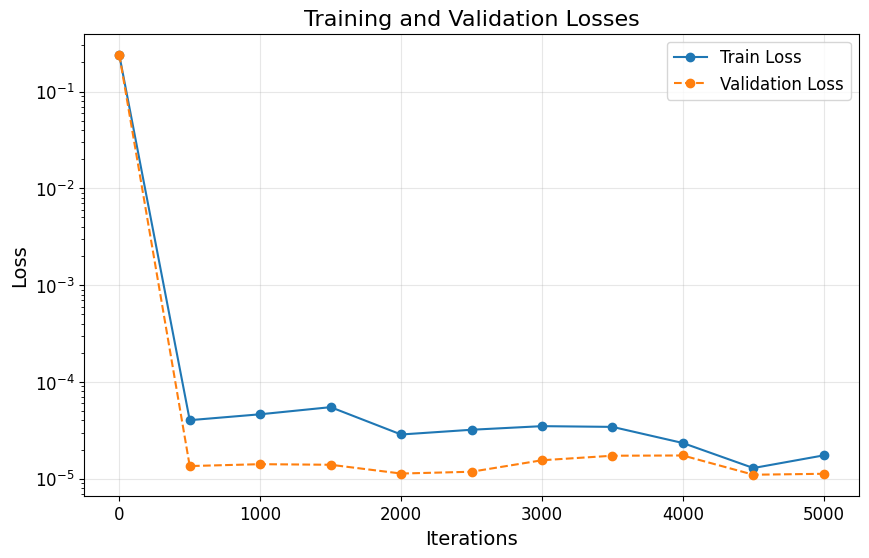

In [ ]:
import matplotlib.pyplot as plt

# Example loss lists (replace these with your actual data)
# Assuming each entry corresponds to the loss value at 500 iterations
print(linear_losses)
train_losses = [item['train'].item() for item in linear_losses]
val_losses = [item['val'].item() for item in linear_losses]

# Define the iteration checkpoints
iterations = [500 * (i) for i in range(len(train_losses))]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_losses, label='Train Loss', marker='o', linestyle='-')
plt.plot(iterations, val_losses, label='Validation Loss', marker='o', linestyle='--')

plt.yscale('log')

# Formatting
plt.title('Training and Validation Losses', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()